# Group 12 - HUM-274: Milestone 2

In [28]:
from math import fabs
from music21 import midi, note, stream, instrument, meter, duration

### 4) Adding complexity back

The previous part sees the deconstruction of the piece down to urban noises. This part stalls a little bit in this realm
of noise by injecting some rhythmic complexity first through a carefully chosen L-System, which we will reuse later.

Indeed, the L-System abstraction is really powerful as you can easily construct complex phenomena with varying effects.
First, here's our general purpose L-System implementation:

In [29]:
class Rule:
    """
    Encodes L Systems' replacement rules.
    """

    def __init__(self, base: str, replacement: str):
        """
        :param base: string,
        :param replacement: string
        """
        self.base = base
        self.replacement = replacement


class LSystem:
    """
    L System's functionality.
    """

    def __init__(self, *rules):
        """
        An L System = a set of rules

        :param rules: List[Rule]
        """
        self.rules = {}
        [self.rules.update({rule.base: rule.replacement}) for rule in rules]

    def replace(self, base, show_mode: bool = False):
        """
        The brains of an L System, doing the simple task of applying each rule recursively

        :param base: some base string
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: result of applications of all replacement rules on base string
        """
        new_string = ""
        for c in base:
            if c in self.rules:
                if show_mode:
                    new_string += "<"
                new_string += self.rules.get(c)
                if show_mode:
                    new_string += ">"
            else:
                new_string += c
        return new_string

    def run(self, initial: str, nb_iterations: int, show_mode: bool = False):
        """
        Applies the replace method nb_iterations times with base string initial

        :param initial: first base string
        :param nb_iterations: how many times rules replacements should occur
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: last result of rule applications
        """
        string = initial
        for i in range(nb_iterations):
            string = self.replace(string, show_mode)
        return string

This abstraction produces strings which are consequently mapped to musical elements. This is where a human can have
control over the L-System. See, for example, this function mapping L-System sequences to durations.

In [30]:
def sequence_from_string_complex(string: str):
    """
    To use with chars: A, B, C, D, E, F, +, -, [, ]
    A: half note
    B: quarter
    C: eighth
    D: sixteenth
    E: triplet
    F: quintuplet
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    ]: divide previous duration by 2
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'C':
            tb.append(1 / 2)
        elif c == 'D':
            tb.append(1 / 4)
        elif c == 'E':
            tb.append(1 / 3)
        elif c == 'F':
            tb.append(1 / 5)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == ']':
            if len(tb) > 0:
                if tb[-1] > float(1.0 / 1024):
                    tb[-1] = tb[-1] / 2
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    def is_duration_char(c: str):
        return c in ['A', 'B', 'C', 'D', 'E', 'F']

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        nb_chars_read = 1

        if str_arr[0] == '+' and len(str_arr) >= 2:
            nb_chars_read = 2
            if len(tab) > 0 and is_duration_char(str_arr[1]):
                old_read = tab[-1]
                new_read = char_to_duration(str_arr[1], tab)
                new_dur = fabs(old_read) + fabs(new_read)
                if old_read < 0:
                    new_dur = -new_dur
                tab[-2] = new_dur
                tab = tab[:-1]

        else:
            char_to_duration(str_arr[0], tab)

        str_arr = str_arr[nb_chars_read:]  # remove chars read
    return tab

As we only care, in this section, about rhythmic quantities, we'll go ahead and use the helper functions given in the
second notebook of the course:

In [61]:
def translate(int_note, dur):
    """
    Given an integer value of a note, get a corresponding music21.note object
    :param int_note: integer value of the note
    :param dur: duration of desired note - if negative, interpret as rest
    :return music21.note
    """
    first_char_arr = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch = first_char_arr[int_note % 12] + str(int(2 + int_note / 12))

    if dur < 0:
        return note.Rest(duration=duration.Duration(quarterLength=-dur))
    return note.Note(pitch, duration=duration.Duration(quarterLength=dur))


def combine_voices(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    :param time_sig: well..
    :param inst: list of used instruments
    :param length: common length of voices to consider
    :param rhythm: rhythmic line: sequence of durations
    :param voices: sequences of integers encoding notes
    :return stream of chords
    """

    if inst is None:
        inst = [instrument.Piano()]
    voices = voices[0]
    score = stream.Score()
    score.timeSignature = meter.TimeSignature(time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        parts[part_index].timeSignature = meter.TimeSignature(time_sig)
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], rhythm[i]))

    for i in range(len(parts)):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score


def play(score):
    # Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()


Last but not least, let's put the pieces together! Let's define some rules and see what comes out.

In [62]:
def rules_complex():
    rule_a = Rule("A", "BB[F+E-D+A]FF")
    rule_b = Rule("B", "D[E]-C""D[E]-C")
    rule_c = Rule("C", "CD+C-CF-")
    rule_d = Rule("D", "AE+[D-D]D+ED")
    rule_e = Rule("E", "[E+-]B")
    rule_f = Rule("F", "F+[-B]B[[A]EF]")
    return LSystem(rule_a, rule_b, rule_c, rule_d, rule_e, rule_f)


def initial_complex():
    return "F]AEE-B"


def run_complex_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


rhythm = sequence_from_string_complex(run_complex_for(4))
length = int(len(rhythm) / 60)
print(f"{length} notes kept")
score = combine_voices(length, rhythm, [[7 for i in range(length)]], inst=None, time_sig="3/4")

##play(score)

51 notes kept
[1, 1, 2, 2, 2, 2, -1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, -1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, -1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, -1, 2, 1, 1, 2, 2, -1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, -1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, -1, 2, 1, 1, 1, 1, 2, 2, 2, 2, -1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, -1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, -1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1]


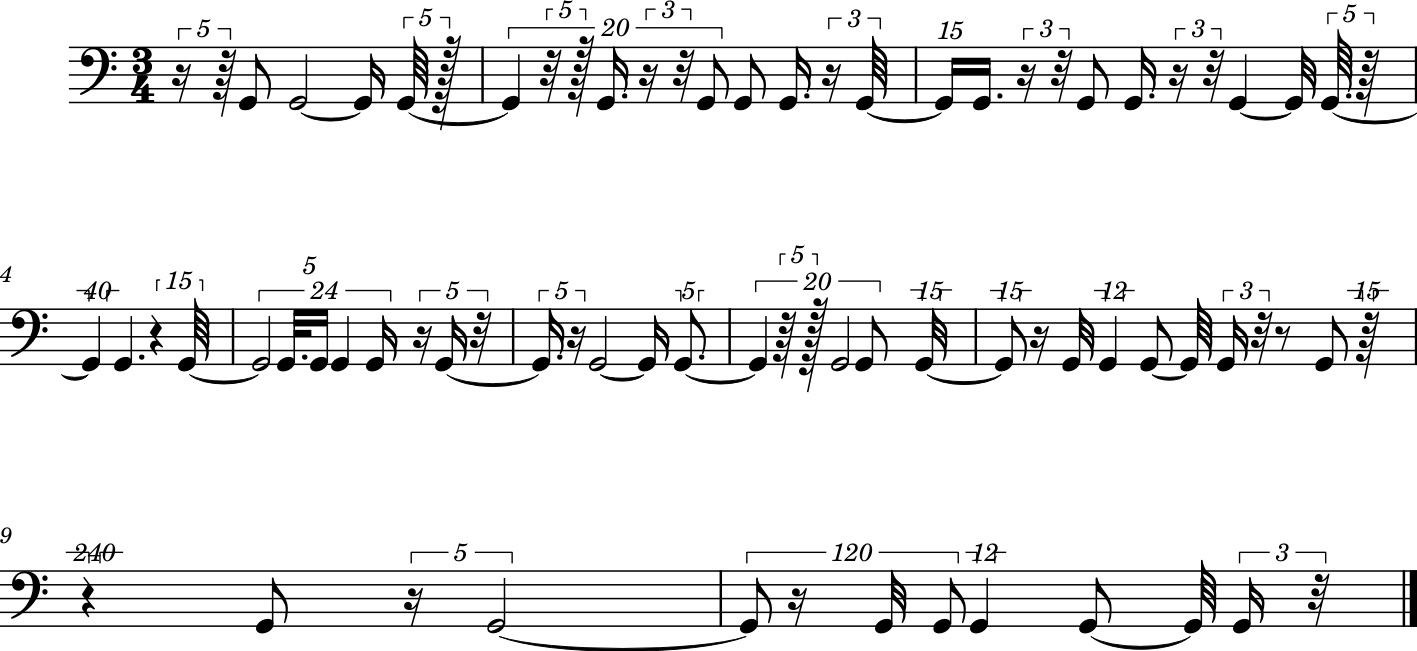

In [63]:
score.show()

JUSTIFY WHY SUCH ERRATIC BEHAVIOUR

And thus a rhythmically erratic
Our next task is to add melodic values to these durations.

### 5) Convergence after chaos
The second to last step of the composition sees a reconvergence to the main theme. Rhythm and melody converge separately
to a theme resembling that of the *Boléro*.

Let's start with rhythm. We need to find an appropriate L-System and a string to durations function. In the previous
section, the artistic choice of complex chaos made it simple to come up with a berzerk L-System that generates
random-sounding notes. The goal is reversed this time: *Boléro*'s main theme is very simple and very repetitive.

In [64]:
def rules_bolero():
    """
    Converge to the Bolero snare drum part: A B A C
    where A = the common first half of the two measures 
              (one eighth note + 3 sixteenths)
          B = A + 2 eighth notes, the second half of the 
              first measure
          C = A + 6 sixteenth notes, the second half of the
              second measure
    """
    return LSystem(
        Rule("A", "ESSS"),
        Rule("B", "ESSSEE"),
        Rule("C", "ESSSSSSSSSZ"),
        Rule("E", "E"),
        Rule("S", "S"),
        Rule("T", "S"),
        Rule("W", "STSTSTTSSE"),
        Rule("X", "WYTTAYYESSYZ"),
        Rule("Y", "BATTWBWTTTTSTTA"),
        Rule("Z", "ABAC")
    )


def initial_bolero():
    return "YWWX"


def run_bolero_for(n, show_mode=False):
    return rules_bolero().run(initial_bolero(), n, show_mode)


def sequence_from_string_bolero(string: str):
    """
    To use with chars in chars_bolero
    Notes with rhythmical values:

    E: eight note
    S: sixteenth note
    T: 32nd note

    A: triplet
    B: two triplets
    C: dotted eight note

    W: quarter note rest
    X: quintuplet
    Y: two quintuplets
    Z: eight note rest

    :param string: input string
    :return: sequence of durations (floats)
    """
    note_durations = {
        "E": 1 / 2,
        "S": 1 / 4,
        "T": 1 / 8,

        "A": 1/3,
        "B": 2/3,
        "C": 3/4,

        "W": -1/4,
        "X": 1/5,
        "Y": 2/5,
        "Z": -1/2
    }

    return [note_durations.get(c) for c in string]

Let's see what this sequence looks like and confirms that it actually converges to *Boléro*'s snare drum part:

In [65]:
bolero_rhythm = run_bolero_for(3, True)
print(f"beginning of the sequence: {bolero_rhythm[:60]}")
print(f"end of the sequence: {bolero_rhythm[-60:]}")

beginning of the sequence: <<<E><S><S><S><E><E>><<E><S><S><S>><<S>><<S>><<S><S><S><S><S
end of the sequence: S><S><S><S><S><S><ESSS>><<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>>>


Now let's see and hear what it sounds like!

In [66]:
bolero_rhythm = sequence_from_string_bolero(run_bolero_for(3, False))
length = int(len(bolero_rhythm))
bolero_score = combine_voices(length, bolero_rhythm, [[3 for i in range(length)]], inst=[instrument.Woodblock()], time_sig="3/4")
play(bolero_score)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
bolero_score.show()

TODO